In [98]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pygame
import h5py

import pandas as pd
import os

In [99]:
data_path  = r'C:\Users\lhauptmann\Code\WristPPG2\data'
save_dir = r'C:\Users\lhauptmann\Code\WristPPG2\data\dataset'
index = 270
participant_name = "jilian_2"



imu_file = f"imu_{index:03d}.txt"
ppg_file = f"ppg_{index:03d}.txt"
label_file = f"labels//label_{index:03d}.csv"
data_file = f"{participant_name}.hdf5"
video_file = f"webcam_recordings//webcam_{index:03d}.avi"

label_path = os.path.join(data_path, label_file)
data_file = os.path.join(save_dir, f"participant_" + participant_name.split("_")[0], f"participant_{participant_name}.hdf5")
video_path = os.path.join(data_path, video_file)

In [100]:



def show_video_from_frames_pygame(frames, fps=30):
    """
    Displays video frames using PyGame, overlays frame IDs, and maintains specified FPS.
    
    Args:
        frames (list): List of video frames (BGR format).
        fps (int): Frames per second for playback.
    
    Returns:
        bool: True if the video plays without interruption; False if 'q' is pressed to quit.
    """
    # Initialize PyGame
    pygame.init()
    clock = pygame.time.Clock()

    # Set up the display window
    frame_height, frame_width = frames[0][0].shape[:2]
    screen = pygame.display.set_mode((frame_width, frame_height))
    pygame.display.set_caption("Video Playback")

    running = True
    for frame_id, frame in enumerate(frames):
        
        frame = frame[0]
        # Handle events (exit on quit or 'q' key)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN and event.key == pygame.K_q:
                running = False
        
        if not running:
            break

        # Convert the frame from BGR (OpenCV format) to RGB (PyGame format)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Overlay the frame ID on the frame
        text = f"Frame: {frame_id}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (200, 30)
        font_scale = 1
        font_color = (255, 255, 255)  # White
        thickness = 2
        line_type = cv2.LINE_AA
        cv2.putText(frame_rgb, text, position, font, font_scale, font_color, thickness, line_type)

        # Convert frame to a surface for PyGame
        frame_surface = pygame.surfarray.make_surface(np.transpose(frame_rgb, (1,0,2)))

        # Display the frame on the PyGame window
        screen.blit(frame_surface, (0, 0))
        pygame.display.flip()

        # Wait to maintain the desired FPS
        clock.tick(fps)

    # Quit PyGame
    pygame.quit()
    return running


    
def plot_frame(frame):
    
    if isinstance(frame, tuple):
        frame = frame[0]
    
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Plot the frame
    plt.imshow(frame_rgb)
    plt.axis('off')  # Optional: turn off axis
    plt.show()

def load_video(video_file):
    
    cap = cv2.VideoCapture(video_file)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames



def load_specific_frames(video_file, frame_indices):
    import cv2
    cap = cv2.VideoCapture(video_file)
    frames = []
    
    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in frame_indices:
        if i < total_frames:
            # Set the video position to the specific frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frames.append(frame)
    
    cap.release()
    return frames

def load_frames_by_time_range(video_file, start_timestamp, end_timestamp, offset = 0, delay_frames = 0):
    import cv2
    cap = cv2.VideoCapture(video_file)
    frames = []
    
    timestamps_file = video_file.replace(".avi", "_timestamps.txt")
    start_time, end_time = None, None
    for line in open(timestamps_file, "r").readlines():
        if line.startswith("Recording Start Time:"):
            start_time = float(line.split(":")[-1])
        if line.startswith("Recording End Time:"):
            end_time = float(line.split(":")[-1])
    
    assert start_time is not None and end_time is not None, "Could not read start and end time from file"
    
    # Get video FPS and total number of frames
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the start and end frame indices
    delay_time = delay_frames * 1/30 # heuristically determined delay
    start_time = start_time + delay_time
    end_time = end_time - delay_time
    
    start_frame = int((start_timestamp - start_time) * fps)  - 0 + offset
    end_frame = int((end_timestamp - start_time) * fps)   +  20 + offset
    print(start_timestamp, end_timestamp, start_time, end_time)

    # Ensure the frame indices are within bounds
    start_frame = max(0, start_frame)
    end_frame = min(total_frames, end_frame)

    for frame_index in range(start_frame, end_frame + 1):
        # Set the video position to the specific frame index
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if ret:
            frame_time = start_time + frame_index / fps
            frames.append((frame, frame_time))
        else:
            break  # Stop if we can't read the frame
    
    cap.release()
    return frames

def show_video_from_frames_pygame(frames, fps=30, track_key=pygame.K_p, post_release_frames=3, gesture = ""):
    """
    Displays video frames using PyGame, overlays frame IDs, and maintains specified FPS.
    Detects when a specific key is pressed and released, and records the corresponding frame indices.
    Plays for a specified number of frames after key release.
    
    Args:
        frames (list): List of video frames (BGR format).
        fps (int): Frames per second for playback.
        track_key (int): Key to track for press/release detection (default: pygame.K_p).
        post_release_frames (int): Number of frames to play after key release.
    
    Returns:
        list: List of tuples (pressed_frame, released_frame) indicating key press/release frame indices.
    """
    # Initialize PyGame
    pygame.init()
    clock = pygame.time.Clock()

    if len(frames) == 0:
        print("No frames to display.")
        return None

    # Set up the display window
    frame_height, frame_width = frames[0][0].shape[:2]
    screen = pygame.display.set_mode((frame_width, frame_height))
    pygame.display.set_caption("Video Playback")

    running = True
    pressed_frame = None
    released_frame = None
    key_events = []  # List to store (pressed_frame, released_frame) tuples
    continue_frames = 0  # Counter for post-release playback

    for frame_id, frame in enumerate(frames):
        frame, frame_time = frame  # Unpack if frame is tuple

        # Handle events (exit on quit or 'q' key, track key press/release)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:  # Exit on 'q'
                    running = False
                elif event.key == track_key:  # Track key press
                    if pressed_frame is None:  # Start of a press
                        pressed_frame = frame_time
            if event.type == pygame.KEYUP and event.key == track_key:  # Track key release
                if pressed_frame is not None:
                    released_frame = frame_time
                    key_events.append((pressed_frame, released_frame))
                    pressed_frame = None  # Reset after release
                    continue_frames = post_release_frames  # Enable post-release playback
        
        if not running:
            break

        # Continue playing for post-release frames
        if continue_frames > 0:
            continue_frames -= 1
            if continue_frames == 0:
                break  # Stop playback after post-release frames

        # Convert the frame from BGR (OpenCV format) to RGB (PyGame format)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Overlay the frame ID on the frame
        text = f"Frame: {frame_id}   Gesture: {gesture}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (200, 30)
        font_scale = 1
        font_color = (255, 255, 255)  # White
        thickness = 2
        line_type = cv2.LINE_AA
        cv2.putText(frame_rgb, text, position, font, font_scale, font_color, thickness, line_type)

        # Convert frame to a surface for PyGame
        frame_surface = pygame.surfarray.make_surface(np.transpose(frame_rgb, (1, 0, 2)))

        # Display the frame on the PyGame window
        screen.blit(frame_surface, (0, 0))
        pygame.display.flip()

        # Wait to maintain the desired FPS
        clock.tick(fps)

    # Quit PyGame
    pygame.quit()
    return key_events


def get_labels_from_hdf5(file_path):
    with h5py.File(file_path, "r") as f:
        labels = f["labels"][:]
    return labels



def add_manual_labels(labels, video_path, specify_gestures:list = [], fps=3, delay_frames=0, frame_offset=20):

    if specify_gestures:
        pinch_labels = labels[labels["label"].isin(specify_gestures)]
    else:
        pinch_labels = labels
    for i, row in pinch_labels.iterrows():
        video_frames = load_frames_by_time_range(video_path, row["start_time"], row["end_time"], delay_frames=delay_frames)

        gesture_frame = show_video_from_frames_pygame(video_frames[frame_offset:], fps=fps, gesture=row["label"])
            
        if not gesture_frame:
            continue
        
        gesture_time_start, gesture_time_end = gesture_frame[0]

        print(f"Corrected Start Time by {row['start_time'] - gesture_time_start} and End Time by {row['end_time'] - gesture_time_end}")
        labels.at[i, "start_time"] = gesture_time_start
        labels.at[i, "end_time"] = gesture_time_end
        
    return labels



In [101]:
label_hdf5_start, labels_df_start, label_hdf5_stop, labels_df_stop

(1733485429.091273, 1733484598.026276, 1733485429.091273, 1733484925.550564)

In [102]:
start_label_keys

['s_1733485429091', 's_1733485763001']

In [105]:
label_id = "p_1733485664276"
labels_df = pd.read_csv(label_path)

with h5py.File(data_file, "r") as f:
    label_keys = [el for el in f.keys() if el != "data"]
    start_label_keys = [el for el in f.keys() if el.startswith("s_")]
    label_hdf5_start = f[start_label_keys[0]]["start_time"][()]
    label_hdf5_stop = f[start_label_keys[0]]["end_time"][()]
    labels_df_start, labels_df_stop = labels_df[labels_df["label"] == "s"]["start_time"].values
    shift = label_hdf5_start - labels_df_start
    print(shift)
    
    label_start = f[label_id]["start_time"][()] - shift
    label_stop = f[label_id]["end_time"][()] - shift
    label_gesture = f[label_id]["label"][()]
    

video_frames = load_frames_by_time_range(video_path, label_start, label_stop)

gesture_frame = show_video_from_frames_pygame(video_frames, fps=3, gesture=label_gesture)


1.6219193935394287
1733485662.6548915 1733485663.9992092 1733485427.4683554 1733485762.3806305


In [6]:
labels_corected = add_manual_labels(labels_df.copy(), video_path, specify_gestures=None, fps=3, delay_frames=0, frame_offset=15)

1733241865.1299362 1733241865.1299362 1733241865.1289353 1733242167.4333143
1733241870.1419446 1733241871.3541873 1733241865.1289353 1733242167.4333143
Corrected Start Time by -0.9869906902313232 and End Time by 0.058585166931152344
1733241871.3551874 1733241872.5148978 1733241865.1289353 1733242167.4333143
Corrected Start Time by -0.6737480163574219 and End Time by 0.18596243858337402
1733241872.5148978 1733241873.9759912 1733241865.1289353 1733242167.4333143
Corrected Start Time by -0.6140375137329102 and End Time by 0.7137224674224854
1733241873.9769917 1733241875.1302226 1733241865.1289353 1733242167.4333143
Corrected Start Time by -0.685276985168457 and End Time by 0.3012871742248535
1733241875.1312227 1733241876.4930477 1733241865.1289353 1733242167.4333143
Corrected Start Time by -0.7977125644683838 and End Time by 0.13077902793884277
1733241876.4930477 1733241877.773304 1733241865.1289353 1733242167.4333143
Corrected Start Time by -0.6025543212890625 and End Time by -0.32229804

In [18]:
labels_corected.to_csv(label_path.replace(".csv", "_corrected.csv"), index=False)

(1733479855.7980158,
 1733480198.3735454,
 <Closed HDF5 dataset>,
 <Closed HDF5 dataset>)

Text(0.5, 1.0, 'Original')

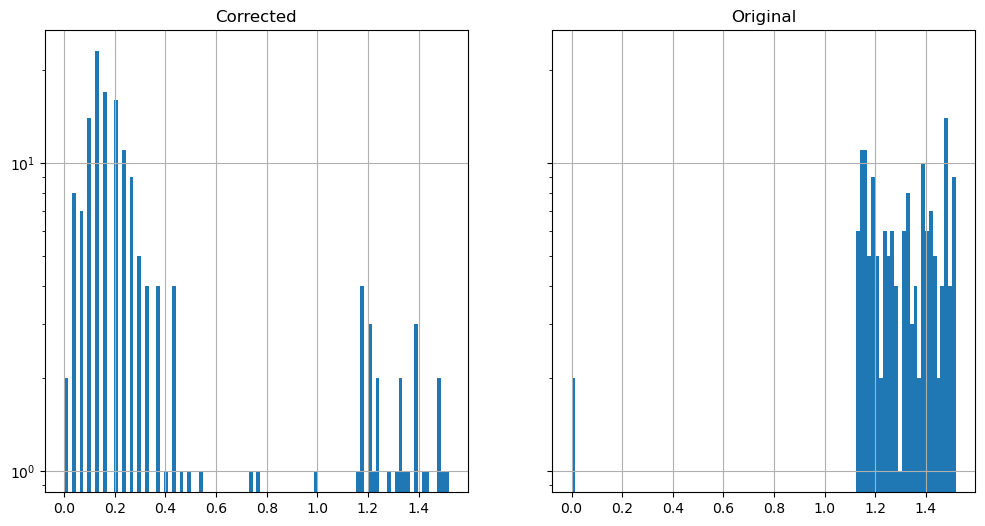

In [14]:
labels_lenth_corrected = labels_corected["end_time"] - labels_corected["start_time"]
labels_length_orig = labels_df["end_time"] - labels_df["start_time"]
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
labels_lenth[labels_lenth < 50].hist(bins=100, log=True, ax=ax[0])
ax[0].set_title("Corrected")
labels_length_orig[labels_length_orig < 50].hist(bins=100, log=True, ax=ax[1])
ax[1].set_title("Original")

<Axes: >

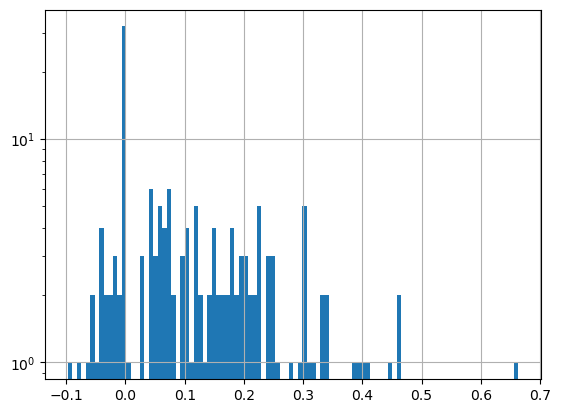

In [15]:
labels_center_corrected = (labels_corected["start_time"] + labels_corected["end_time"]) / 2
labels_center_orig = (labels_df["start_time"] + labels_df["end_time"]) / 2

labels_center_shift = labels_center_corrected - labels_center_orig
labels_center_shift.hist(bins=100, log=True)

# generally, the corrected labels are larger than the original labels

In [17]:
(labels_df["end_time"] < labels_corected["end_time"]).sum()

4